# Notebook for developing trajectory overlap function
Here we estimate an index which will indicate how much do trajectories from different sessions of the same fish differ/overlap. Ideally the output is one number or a heatmap for maze/individual arms.

In [1]:
import itertools

In [2]:
import numpy as np
import pandas as pd
from importlib import reload

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import anchovy.md as md
import anchovy.plotting as aplt
import anchovy.geom_utils as gu

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'


**Steps:**
* split area into bins (**what's the optimal bin size?**)
* count amount of time spent per bin (**see heatmap trajectory in occupancy notebook**)
* normalize counts to total time of a session
* compare counts in corresponding bins of two sessions; calculate an index for each bin, based on either
        ABSOLUTE difference
                                 1 if count is 0 in one but not the other bin (no overlap)
        |bin1-bin2|/(bin1+bin2)= :
                                 0 if counts are the same (max overlap)
or 
        DIFFERENCE
                                   1 if count 0 in bin1 but not the bin2 (no overlap) -> increase in bin2
        (bin2-bin1)/(bin1+bin2)=   0 if counts are the same
                                  -1 if count 0 in bin2 but not the bin1 (no overlap) -> reduction in bin2
* average over all bins?
! exclude bins in which both counts are 0

**Questions:**
* is it right to give same weights to the bins in influencing the average?(i.e. bins which were visited more and overlap could be more significant?)
* is it right to normalize the bins? (i.e. if the same amount of time was spent in bin during a long and a short session, after normalization amount of time would be different)

**Caveats:**
* this will work only for comparing raw trajectory overlaps within the same experiment, because trajectories are aligned
* for comparing trajectory overlaps between different experiments, mazes have to be aligned (including translation, rotation and scaling!). However there's no current need to do this anyway.

In [5]:
ssa = md.ssa_new
# pick a random experiment id from training sessions (control+shock sessions)

In [94]:
def calc_limits(ss):
    ss_part = pd.read_hdf(ss.ss_coords_path)
    
    # find boundaries of trajectories for bin calculation
    xmin, xmax, dx = gu.minmax(ss_part.x.values)
    ymin, ymax, dy = gu.minmax(ss_part.y.values)
    return xmin, xmax, ymin, ymax


In [99]:
def calc_overlap_hist(ss_pair, arm=None, cell=10):
    """ Calculate a 2D histogram from trajectory data 
    
    Parameters:
    ----------
    ss_pair  : a df with information about sessions, for which
               histograms are calculated
    arm      : arm, for which histogram is calculated
               if None, histogram is calculated for whole trajectory
    cell     : size of bins for histogram (cellxcell)
    
    Returns:
    -------
    a      : a list of histograms, one for a session
    a_len  : a list of session lengths
    """
    a = []
    a_len = []
    a_co = []
    axmin, axmax, aymin, aymax = 9999, -9999, 9999, -9999
    j = 0
    for i, ss in ss_pair.iterrows():
        if j == 0:
            ss_part = pd.read_hdf(ss.ss_coords_path)[-36000:]
            j = 1
        else:
            ss_part = pd.read_hdf(ss.ss_coords_path)[:36000]    
        if arm is not None:
            ss_part.loc[ss_part.arm != arm] = np.NaN
        a_co.append(ss_part)

        # find boundaries of trajectories for bin calculation
        xmin, xmax, ymin, ymax = calc_limits(md.ssa.loc[md.ssa.xp_id == ss.xp_id].iloc[0])
        axmin = min(xmin, axmin)
        aymin = min(ymin, aymin)
        axmax = max(xmax, axmax)
        aymax = max(ymax, aymax)

    xbins = np.arange(axmin-20, axmax+20, cell)
    ybins = np.arange(aymin-20, aymax+20, cell)
    if (len(xbins) == 0) or (len(ybins) == 0):
        return None, None

    for ss_part in a_co:
        # calculate histogram and clip it to threshold value
        cohist = np.histogram2d(ss_part['x'], ss_part['y'],
                                bins=(xbins, ybins))[0]
        # co_clipped = cohist.clip(max=thresh)
        a.append(cohist.copy())
        a_len.append(ss_part.shape[0])
    return a, a_len

In [7]:
def norm_overlap_hist(a, a_len):
    """ Normalize values in each bin of histogram 
    in correspondence to duration of a session
    
    Parameters:
    ----------
    a     : a list with histograms
    a_len : a list with durations of histograms, 
            which correspond to histograms in a
    
    Returns:
    -------
    a_norm  : list of normalized histograms
    """
    max_stay = max(a_len)
    a_norm = []
    for l, aa in zip(a_len, a):    
        aa = aa*max_stay/l
        #aa = aa/l
        a_norm.append(aa)
    return a_norm

In [104]:
def overlap_ind(pair, ab, bin_norm=True, arm=None, norm=True, cell=10):
    """ Calculate overlap index for trajectories of a pair of sessions
    
    Parametes:
    ---------
    pair  : a df with information about sessions, for which
            overlap is calculated
    ab    : True if absolute values of difference in trajectories are calculated
    arm   : arm for which overlap is calculated
            if None, overlap is calculated for whole trajectory
    norm  : True if trajectories are normalized to session durations
    bin_norm : True if each bin diff is divided by bin sum
    cell  : size of bins - coarseness of analysis
    
    Returns:
    ------- 
    ov_ind : overlap index of the pair
    adiv   : a 2D array with individual indeces in each bin
    """
    a, a_len = calc_overlap_hist(pair, arm=arm, cell=cell)
    if type(a) == type(None):
        return np.NaN, None  # if there was no movement for this arm value
    
    if norm:
        a = norm_overlap_hist(a, a_len)
    is0 = np.where((a[0]+a[1]) == 0)  # this deals later with NaN values
    a_sum = a[0]+a[1]
    a_sum[is0] = 1
    
    if ab:
        adiff = abs(a[1]-a[0])
    else:
        adiff = a[0]-a[1]

    if bin_norm:
        adiv = np.divide(adiff, a_sum)
        #adiv = abs(a[1]-a[0])
    else:
        adiv = adiff
        #adiv = a[0]-a[1]
    adiv[is0] = np.NaN
    ov_ind = np.nanmean(adiv)
    if ab:
        # for plotting purporses (colormap looks better)
        adiv = - adiv
    
    return ov_ind, adiv

In [90]:
arms = [None, 0, 1, 2, 3]
def xp_overlap(xp_id, bin_norm=True, ab=False, cell=10):
    """ Calculate overlap index for pairs of sessions within one experiment
    
    Parameters:
    ----------
    xp_id : id of an experiment
    ab    : True if absolute values of difference in trajectories are calculated
    cell  : size of bins - coarseness of trajectory analysis
    
    Returns:
    -------
    """
    ss_sub = ssa.loc[ssa.xp_id == xp_id]
    ss_ids = ss_sub['ss_id'].values
    ss_pairs = itertools.combinations(ss_ids, 2)
    for p in ss_pairs:
        print(p)
        for arm in arms:
            ov_ind, adiv = overlap_ind(ss_sub.loc[ss_sub.ss_id.isin(p)], ab, bin_norm=bin_norm, arm=arm, cell=cell)
            h_max = np.nanmax(abs(adiv))
            #adiv /= h_max
            ov_ind /= h_max
            if arm is None:
                plt.figure(figsize=(8,8))
                plt.grid(b=False)
                if ab:
                    m = 'viridis'
                else:
                    m = 'RdBu'
                cmap = plt.get_cmap(m)
                cmap.set_bad(color=(0.5, 0.5, 0.5))  # grey color for NaN values
                # transpose histogram because pyplot.imshow flips axes
                plt.imshow(adiv.T, cmap=m, interpolation='nearest')
                plt.show()
            print(arm, -ov_ind)

If ab=False, overlap_index is 0 if trajectories are very similar, -1 (red) if second session in the pair had much higher occupancy, 1 (blue) if second session in the pair had much lower occupancy

    'white' = same occupancy
    'blue'  = decreased occupancy in second session of the pair
    'red'   = increased occupancy in second session of the pair

If ab=True, overlap_index is 0 (dark blue) if trajectories are very similar, 1 (yellow) if one session in the pair had much higher occupancy than the other

    'dark blue' = same occupancy
    'yellow'  = zero occupancy in one of the arms

**`Grey` indicates that fish hasn't visited that sector of the maze (bin) in either of compared sessions!**

In [79]:
# load a random xp from test experiments 
xp = ssa.loc[ssa.xp_type == 'test', 'xp_id'].sample(1).values[0]
print(xp)

280717-04-01


In [16]:
ssa.loc[ssa.xp_id == xp].iloc[1].ss_coords_path

'C:\\Users\\yashina/Dropbox/zfish_analysis/hdf_center_coordinates\\280717-06-01-01.h5'

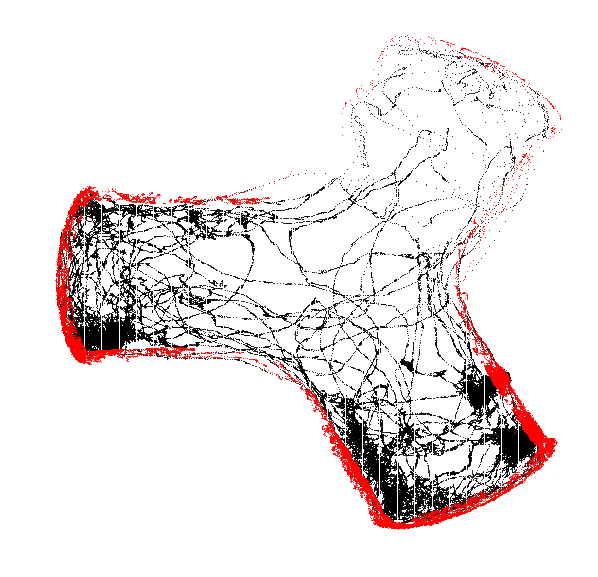

In [83]:
# plot one of experiment's sessions
reload(aplt)
f, ax = aplt.plot_ss(ssa.loc[ssa.xp_id == xp].iloc[1], s=1)
bord_xy = pd.read_hdf('C:/Users/yashina/projects/fishy_vr/coords/test_{}.h5'.format(ssa.loc[ssa.xp_id == xp, 'ss_id'].iloc[1]))
bord_xy = bord_xy.loc[bord_xy.thigmo < 15, ['yfix', 'xfix']]
# !!! plot_ss plots x and y, and borders were calculated for sx and sy,
# below I plot sx&sy borders in red
ax.scatter(bord_xy['yfix'], bord_xy['xfix'], color='r', s=1)
plt.show()

140218-01-01
('140218-01-01-00', '140218-01-01-01')


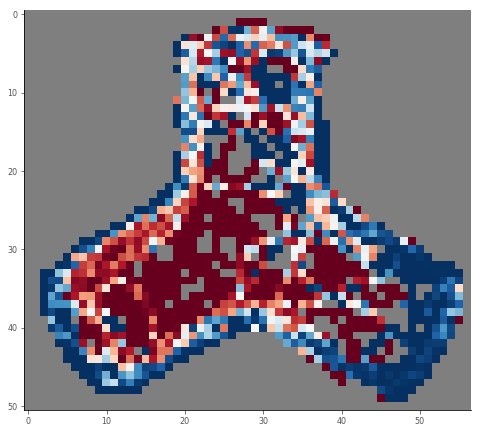

None 0.03322932020987962
0 -0.35257252311365567
1 -0.14049966625529167
2 0.16164205406844742
3 0.3352046357780864
('140218-01-01-00', '140218-01-01-02')


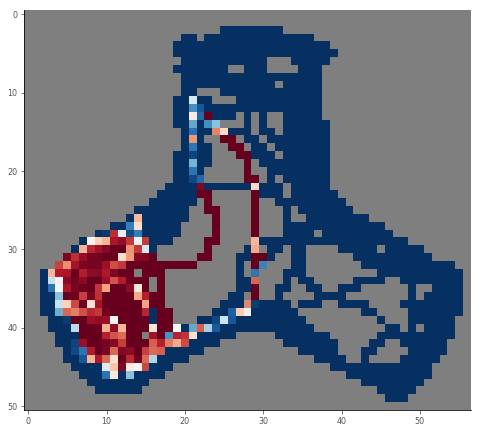

None -0.5609469888146069
0 -1.0
1 -0.9108036616194598
2 0.23200270375769194
3 -0.6928882574885956
('140218-01-01-01', '140218-01-01-02')


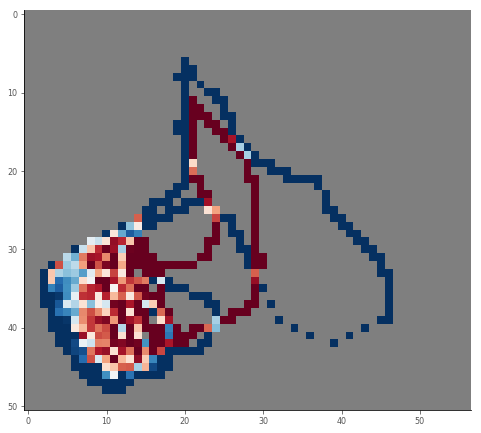

None -0.05444794493023987
0 -1.0
1 -0.2516469038208169
2 0.09238449293924719
3 -0.14654290023837482


In [114]:
# load a random xp and estimate overlap between trajectories of its sessions
# xp = ssa.loc[ssa.xp_type == 'test', 'xp_id'].sample(1).values[0]
xp = '140218-01-01'
print(xp)
xp_overlap(xp, ab=False, bin_norm=True, cell=10)